In [ ]:
!pip install transformers datasets scikit-learn matplotlib seaborn pandas torch

In [ ]:
!pip install transformers --upgrade

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.utils.data import DataLoader, Dataset, random_split
from torch.optim import AdamW
from transformers import get_scheduler
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import random
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load and analyse the data

In [ ]:
# Load your file
data = pd.read_csv('/content/drive/MyDrive/spam_assassin.csv')

In [ ]:
# Look at the first few rows
print(data.head())

                                          Email Text  Email Type
0  From ilug-admin@linux.ie Mon Jul 29 11:28:02 2...         0.0
1  From gort44@excite.com Mon Jun 24 17:54:21 200...         1.0
2  From fork-admin@xent.com Mon Jul 29 11:39:57 2...         1.0
3  From dcm123@btamail.net.cn Mon Jun 24 17:49:23...         1.0
4  From ilug-admin@linux.ie Mon Aug 19 11:02:47 2...         0.0


In [ ]:
# Check data structure
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5797 entries, 0 to 5796
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Email Text  5791 non-null   object 
 1   Email Type  5793 non-null   float64
dtypes: float64(1), object(1)
memory usage: 90.7+ KB
None


Clean and Preprocess Data

In [ ]:
# Check for nulls
print(data.isnull().sum())

Email Text    6
Email Type    4
dtype: int64


In [ ]:
# Drop NA values if any
data = data.dropna()

In [ ]:
# Check for nulls
print(data.isnull().sum())

Email Text    0
Email Type    0
dtype: int64


In [ ]:
# Check the label distribution
print(data['Email Type'].value_counts())

Email Type
0.0    3896
1.0    1895
Name: count, dtype: int64


In [ ]:
# Check the text distribution
print(data['Email Text'].value_counts())

Email Text
Return-Path: ler@lerami.lerctr.org Delivery-Date: Thu Sep 12 22:16:37 2002 Return-Path: <antonyfdy@accesocero.es> Received: from mail.cheerco.net (www-int.cheerleading.com [64.90.53.12]) by lerami.lerctr.org (8.12.2/8.12.2/20020902/$Revision: 1.30 $) with ESMTP id g8D3GXE9027238 for <ler@lerctr.org>; Thu, 12 Sep 2002 22:16:35 -0500 (CDT) Received: from gelincik.trnet.com (gelincik.tr.net [195.155.1.7]) by mail.cheerco.net (8.12.5/8.12.5) with ESMTP id g8D3GRwV080845 for <webmaster@cheerleading.com>; Thu, 12 Sep 2002 22:16:30 -0500 (CDT) (envelope-from antonyfdy@accesocero.es) Received: from correo.ruraltour.com ([195.155.94.48]) by gelincik.trnet.com (InterMail vK.4.02.00.09 201-232-116-109 license 0f5baaa7065154cd09644893d36baf5e) with SMTP id <20020913030633.DLCL13768.gelincik@correo.ruraltour.com>; Fri, 13 Sep 2002 06:06:33 +0300 From: "Beatrice Nestor" <antonyfdy@accesocero.es> To: "EXPANDING MARKETS" <3456@register.com> Subject: -> IN THE NEWS TODAY <---- MIME-Version: 

In [ ]:
# Optional: Shuffle the data
data = data.sample(frac=1).reset_index(drop=True)

EDA and Visualization

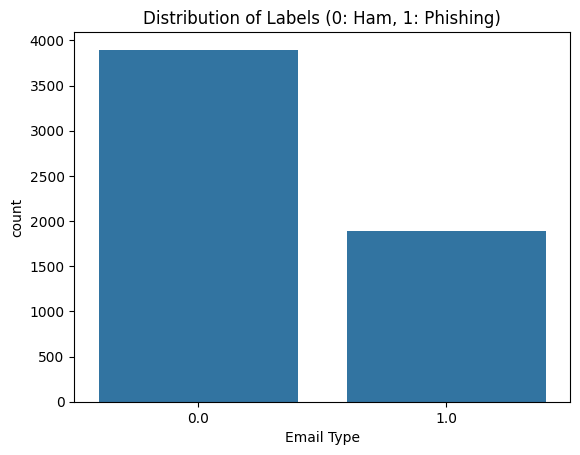

In [ ]:
# Visualize class distribution
sns.countplot(x='Email Type', data=data)
plt.title('Distribution of Labels (0: Ham, 1: Phishing)')
plt.show()

In [ ]:
# Rename the columns
data = data.rename(columns={'Email Type': 'label', 'Email Text': 'text'})

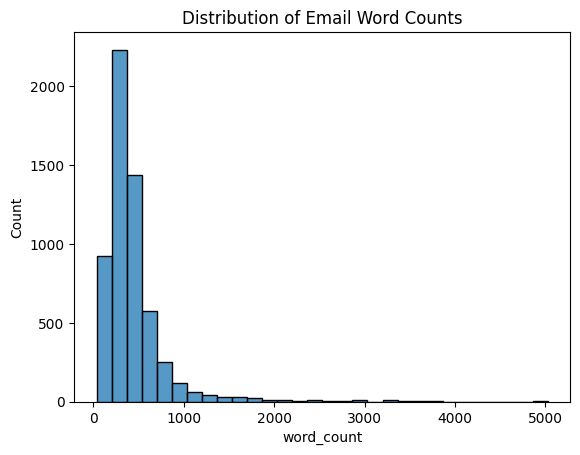

In [ ]:
# Word count distribution
data['word_count'] = data['text'].apply(lambda x: len(x.split()))
sns.histplot(data['word_count'], bins=30)
plt.title('Distribution of Email Word Counts')
plt.show()

Prepare Data for Distil BERT

In [ ]:
# Split dataset
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data['text'].tolist(),
    data['label'].tolist(),
    test_size=0.2,
    random_state=42
)

In [ ]:
# Load BERT tokenizer
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
#load Distil Bert Tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Tokenize - decrese max_length for no memory issues
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=256)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=256)

In [ ]:
class EmailDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
# Create datasets
train_dataset = EmailDataset(train_encodings, train_labels)
test_dataset = EmailDataset(test_encodings, test_labels)

Build BERT Classifier

In [ ]:
# Load pre-trained model
# model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Move model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


Train the Model

In [ ]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [ ]:
# Optimizer and Scheduler
optimizer = AdamW(model.parameters(), lr=5e-5)
num_epochs = 4
num_training_steps = num_epochs * len(train_loader)

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

In [ ]:
# Trackers
train_losses = []
train_accuracies = []

In [ ]:
# Training Loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(**batch)
        loss = outputs.loss
        logits = outputs.logits

        total_loss += loss.item()

        preds = torch.argmax(logits, dim=-1)
        correct += (preds == batch['labels']).sum().item()
        total += batch['labels'].size(0)

        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        torch.cuda.empty_cache()

    avg_loss = total_loss / len(train_loader)
    accuracy = correct / total

    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)

    print(f"Epoch {epoch+1} / {num_epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

Epoch 1 / 4, Loss: 0.2419, Accuracy: 0.9104
Epoch 2 / 4, Loss: 0.1138, Accuracy: 0.9657
Epoch 3 / 4, Loss: 0.0687, Accuracy: 0.9778
Epoch 4 / 4, Loss: 0.0575, Accuracy: 0.9812


In [ ]:
torch.cuda.empty_cache()

Save the Model

In [ ]:
# Save the model and tokenizer
model_save_path = "/content/bert_phishing_detector"

model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)

print("Model and tokenizer saved successfully!")

Model and tokenizer saved successfully!


Visualize Training Progress

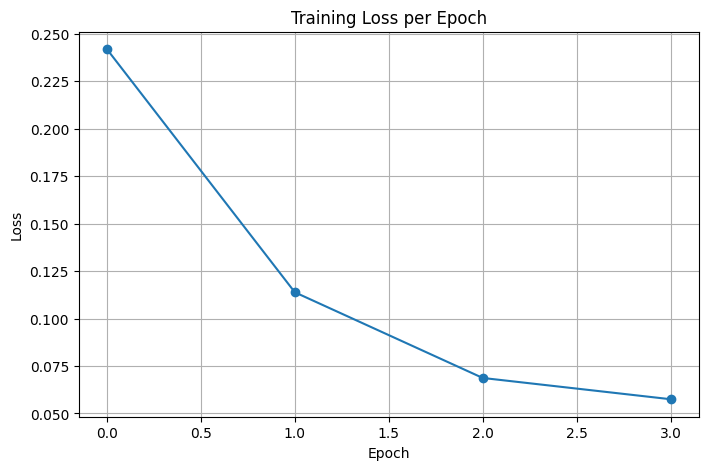

In [ ]:
# Plot Loss
plt.figure(figsize=(8,5))
plt.plot(train_losses, marker='o')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

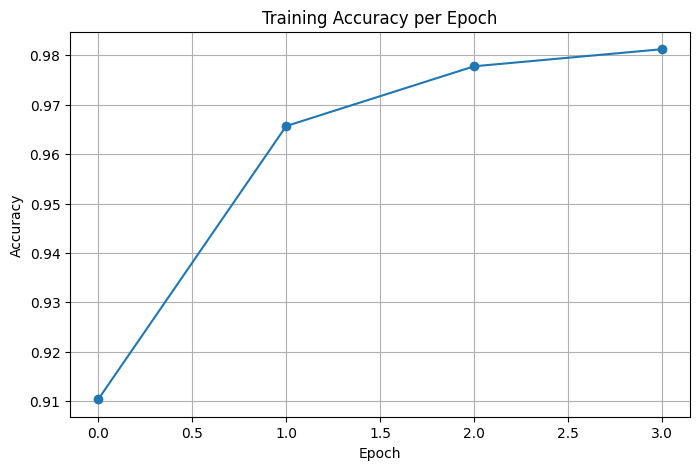

In [ ]:
# Plot Accuracy
plt.figure(figsize=(8,5))
plt.plot(train_accuracies, marker='o')
plt.title('Training Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

Load the Model Later for Evaluation

In [ ]:
# Load model and tokenizer
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

loaded_tokenizer = DistilBertTokenizer.from_pretrained(model_save_path)
loaded_model = DistilBertForSequenceClassification.from_pretrained(model_save_path)

loaded_model.to(device)
loaded_model.eval()

print(" Model and tokenizer loaded successfully!")

 Model and tokenizer loaded successfully!


Evaluate Loaded Model on Test Set

In [ ]:
# Evaluate
predictions = []
true_labels = []

for batch in test_loader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = loaded_model(**batch)
    logits = outputs.logits
    preds = torch.argmax(logits, dim=-1)

    predictions.extend(preds.cpu().numpy())
    true_labels.extend(batch['labels'].cpu().numpy())


In [ ]:
# Metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

report = classification_report(true_labels, predictions, output_dict=True)
cm = confusion_matrix(true_labels, predictions)

print("Classification Report:\n", classification_report(true_labels, predictions))

# Accuracy
print(f"Test Accuracy: {accuracy_score(true_labels, predictions)*100:.2f}%")

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98       794
           1       0.99      0.93      0.96       365

    accuracy                           0.98      1159
   macro avg       0.98      0.96      0.97      1159
weighted avg       0.98      0.98      0.98      1159

Test Accuracy: 97.67%


In [ ]:
def predict_email(text):
    model.eval()
    encoding = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    encoding = {k: v.to(device) for k, v in encoding.items()}
    with torch.no_grad():
        outputs = model(**encoding)
    logits = outputs.logits
    preds = torch.argmax(logits, dim=-1)
    return 'Phishing' if preds.item() == 1 else 'Ham'

# Test prediction
email = "Congratulations! You've won a $1000 gift card. Click here to claim now!"
print(predict_email(email))

Ham


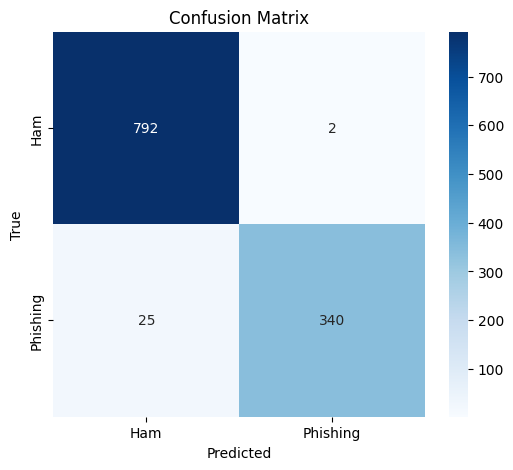

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you already have true_labels and predictions
cm = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Ham", "Phishing"], yticklabels=["Ham", "Phishing"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

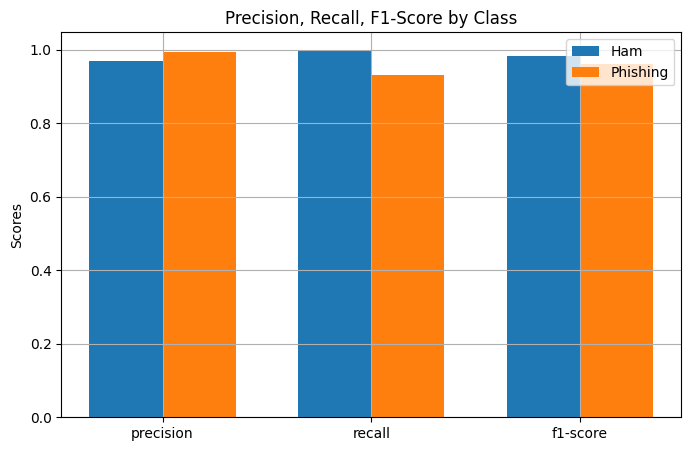

In [ ]:
# Plot Precision, Recall, F1
metrics_names = ['precision', 'recall', 'f1-score']
ham_scores = [report['0'][metric] for metric in metrics_names]
phishing_scores = [report['1'][metric] for metric in metrics_names]

x = np.arange(len(metrics_names))
width = 0.35

fig, ax = plt.subplots(figsize=(8,5))
rects1 = ax.bar(x - width/2, ham_scores, width, label='Ham')
rects2 = ax.bar(x + width/2, phishing_scores, width, label='Phishing')

ax.set_ylabel('Scores')
ax.set_title('Precision, Recall, F1-Score by Class')
ax.set_xticks(x)
ax.set_xticklabels(metrics_names)
ax.legend()
plt.grid(True)
plt.show()

* Results

This project presents a fine-tuned DistilBERT model for phishing email detection, aiming to classify emails as either ham (legitimate) or phishing (malicious). The approach involves preprocessing email text, tokenizing with DistilBERT tokenizer, fine-tuning the model for binary classification, and evaluating its performance on real-world email data.

The model achieved an impressive test accuracy of 97.67%, with a phishing detection precision of 99% and a ham detection recall of 100%. This demonstrates the model’s effectiveness in cybersecurity applications, providing a lightweight and accurate tool for automatically filtering scam emails with minimal false positives.